## Midterm BME 502 2025

In this midterm exam, you are tasked to develop a method to tell whether data is better described by a line fit or a sigmoidal fit.

In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks`


In [2]:
Pkg.add(["Plots","Distributions","Random","Roots","Statistics","NonlinearSolve","LsqFit","ForwardDiff"])

   Resolving package versions...
  No Changes to `C:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks\Project.toml`
  No Changes to `C:\Users\Hasta\OneDrive\Documents\!!SBU BME (B.E.-M.S.)\BME 502 (Analy App Bio Syst)\BME-502-2025-homeworks\Manifest.toml`


In [3]:
using Plots, Distributions, Random, Roots, Statistics, NonlinearSolve, LsqFit, ForwardDiff, LinearAlgebra

In [4]:
line_fit(x,p) = p[1] .+ p[2] .* x

line_fit (generic function with 1 method)

In [5]:
sigmoid_fit(x,p) = p[1] .+ p[2] ./ (1 .+ exp.(-p[3]*(x .- p[4])))

sigmoid_fit (generic function with 1 method)

Let's create some plots to see how these functions look

In [6]:
x = 0:0.1:10

0.0:0.1:10.0

In [7]:
y_line = line_fit(x,[2,0.5])

2.0:0.05:7.0

In [8]:
y_sigmoid = sigmoid_fit(x,[2.5,3.5,0.1,5.5])

101-element Vector{Float64}:
 3.7805254314621974
 3.788656537923644
 3.796809108114118
 3.8049828179038157
 3.8131773393604975
 3.8213923407935093
 3.8296274867991844
 3.837882438307629
 3.8461568526308625
 3.854450383512326
 ⋮
 4.57010642451473
 4.5785558602695
 4.586989447538757
 4.595406810393582
 4.603807575969294
 4.612191374526542
 4.620557839511163
 4.6289066076128
 4.637237318822277

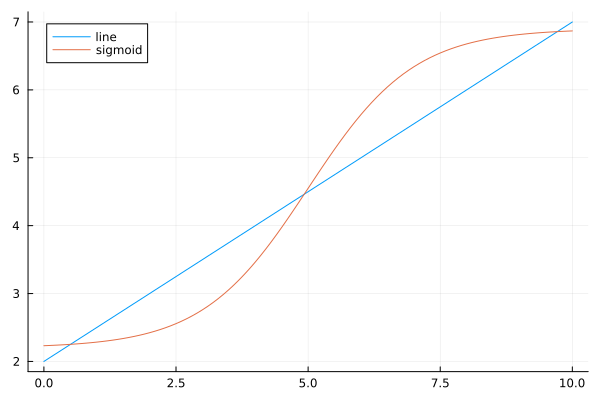

In [9]:
y_line = line_fit(x,[2,0.5])
y_sigmoid = sigmoid_fit(x,[2.2,4.7,1,5.0])
plot(x, y_line, label = "line")
plot!(x, y_sigmoid, label = "sigmoid")

Let us add some serious noise to it

In [10]:
nd = Normal(0,5)
x_line = 10*rand(200)
y_line_n = line_fit(x_line,[2,0.5]) .+ rand(nd,length(x_line))
x_sigmoid = 10*rand(200)
y_sigmoid_n = sigmoid_fit(x_sigmoid,[2.2,4.7,1,5.0]) .+ rand(nd,length(x_sigmoid))

200-element Vector{Float64}:
  6.199601519841529
 12.988401212941893
  1.8328420666709735
 13.618026367147394
 -1.192528394502129
  1.7898391351863188
  3.249984297033335
  5.111323016664445
  8.217070080010178
  6.438370081994123
  ⋮
  5.2673579241538375
  8.865447667859273
 13.415907252374344
  4.190258316767767
 11.886080115536755
 14.558062914601345
  9.711809933389667
  3.672293481859661
 -0.09903880307969892

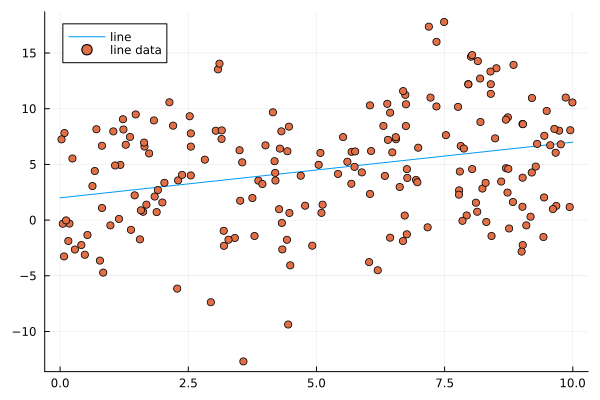

In [11]:
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")

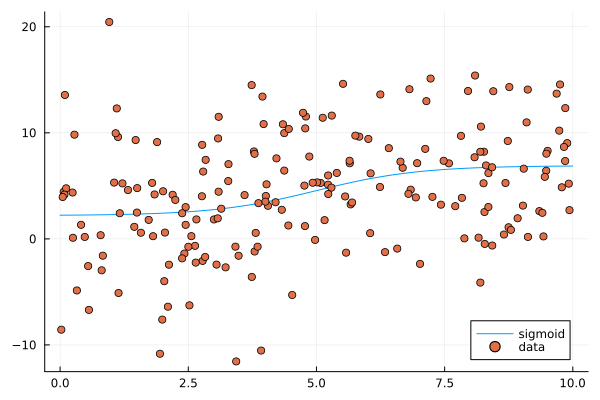

In [12]:
plot(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "data")

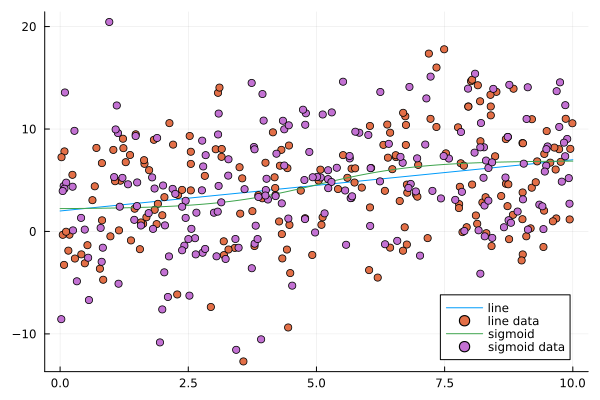

In [13]:
# let's plot it all together
plot(x, y_line, label = "line")
scatter!(x_line, y_line_n, label = "line data")
plot!(x, y_sigmoid, label = "sigmoid")
scatter!(x_sigmoid, y_sigmoid_n, label = "sigmoid data")

# Question:

If you take the sigmoid data, which fit is better? The linear or sigmoid?

How uncertain are the parameters?

At what noise level are the two fits equally likely?

# Part 1 (20 points)
Create a function line_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix.  The standard deviation of the measurement error, sigma, can be supplied as a number (assuming that all measurements share the same error) or as a vector with the same length as y. If sigma (standard deviation of measurement error) is not specified (sigma=[]), estimate the measurement error using the sum of least squares to estimate $\mathcal{X}^2$.

In [14]:
# Line model (linear fitting model)

function line_model(x, p)
    # Extract parameters for the linear model
    intercept, slope = p  # [intercept, slope]
    
    # Define the linear model: y = intercept + slope * x
    return intercept .+ slope .* x
end

# Line fitting function

function line_fitting(x, y; sigma=ones(length(x)), p0=[2, 0.5], λ=1.0, β=1.0)
    # Curve fitting
    fit = curve_fit(line_model, x, y, p0)
    
    # Chi-squared function (for goodness of fit)
    chi2(p) = sum(abs2, (line_model(x, p) .- y) ./ sigma)
    
    # Posterior ratio (using example priors)
    posterior_ratio = λ * β * sum(fit.param)  # You can replace this with a real Bayesian likelihood later
    
    # Return fitted parameters, covariance matrix, chi-squared value, and posterior ratio
    return fit.param, inv(2 * ForwardDiff.hessian(chi2, fit.param)), chi2(fit.param), posterior_ratio
end

line_fitting (generic function with 1 method)

# Part 2 (20 points)
Similarily, create a function sigmoid_fitting(x,y; sigma=[]) that returns the best parameters and the covariance matrix. Treat sigma the same way as in Part 1.

In [15]:
# Sigmoid model function

function sigmoid_model(x, β)
    # Extract parameters for the sigmoid model
    offset, amplitude, steepness, midpoint = β  # [offset, amplitude, steepness, midpoint]
    
    # Define the sigmoid model: offset + amplitude / (1 + exp(-steepness * (x - midpoint)))
    return offset .+ amplitude ./ (1 .+ exp.(-steepness .* (x .- midpoint)))
end

# Sigmoid fitting function

function sigmoid_fitting(x, y; sigma=ones(length(x)), β0=[2.2, 4.7, 1, 5.0], λ=1.0, β=1.0)
    # Curve fitting
    fit = curve_fit(sigmoid_model, x, y, β0)
    
    # Chi-squared function (for goodness of fit)
    chi2(β) = sum(abs2, (sigmoid_model(x, β) .- y) ./ sigma)
    
    # Posterior ratio (using example priors)
    posterior_ratio = λ * β * sum(fit.param)
    
    # Return fitted parameters, covariance matrix, chi-squared value, and posterior ratio
    return fit.param, inv(2 * ForwardDiff.hessian(chi2, fit.param)), chi2(fit.param), posterior_ratio
end

sigmoid_fitting (generic function with 1 method)

# Part 3 (30 points)
Create a function p_ratio_sig_line(x,y; sigma=[]) that returns the Posterior ratio between a fit to a sigmoid and to a line.  Treat sigma the same way as in Part 1-2.

In [16]:
# Posterior ratio function between sigmoid and line models

function p_ratio_sig_line(x, y; sigma=[])
    # Fit both models using previously defined functions
    line_params, line_cov, line_chi2 = line_fitting(x, y, sigma=sigma)
    sigmoid_params, sigmoid_cov, sigmoid_chi2 = sigmoid_fitting(x, y, sigma=sigma)
    
    # Compute the log likelihoods (log of chi-squared values)
    log_likelihood_line = -0.5 * line_chi2
    log_likelihood_sigmoid = -0.5 * sigmoid_chi2
    
    # Return the ratio of posterior likelihoods
    return exp(log_likelihood_sigmoid - log_likelihood_line)
end

p_ratio_sig_line (generic function with 1 method)

# Part 4 (30 points)
Create a function sig_p_ratio_is_one(x,y; sigma=[]) that returns the measurement error (either as a number or array depending on how the sigma is supplied) that would result in a posterior ratio between sigmoid and line of one. If sigma is not provided (sigma=[]), proceed as in Part 1-3.

In [17]:
# Function to find the measurement error that results in a posterior ratio of 1

function sig_p_ratio_is_one(x, y; sigma=[])
    # Compute the posterior ratio for the initial sigma
    ratio = p_ratio_sig_line(x, y, sigma=sigma)
    
    # Try different values of sigma (measurement error) until the posterior ratio is 1
    if ratio > 1
        while ratio > 1
            sigma *= 1.1  # Increase the measurement error gradually
            ratio = p_ratio_sig_line(x, y, sigma=sigma)
        end
    else
        while ratio < 1
            sigma *= 0.9  # Decrease the measurement error gradually
            ratio = p_ratio_sig_line(x, y, sigma=sigma)
        end
    end
    
    # Return the sigma value that results in a posterior ratio of 1
    return sigma
end

sig_p_ratio_is_one (generic function with 1 method)

## Programming Advice:
To make your program more efficient you should think about creating functions that provide information that you can use for all of the parts.  Don't write each function individually, but think what are the common task that need to be done, and then call these more general functions, to get you the result for the specific questions.  I will reward good programming style with a bonus 10 points total.

In [18]:
# Define sequence of program events and function calls

function run_program()
    # Define x values
    x = LinRange(0, 10, 100)
    
    # Define line and sigmoid parameters
    line_params = [2, 0.5]  # [intercept, slope]
    sigmoid_params = [2.2, 4.7, 1, 5.0]  # [offset, amplitude, steepness, midpoint]
    
    # Generate the true values for line and sigmoid functions
    y_line_true = line_params[1] .+ line_params[2] .* x
    y_sigmoid_true = sigmoid_params[1] .+ sigmoid_params[2] ./ (1 .+ exp.(-sigmoid_params[3] .* (x .- sigmoid_params[4])))
    
    # Add noise to the data
    noise_level = 0.5  # Set the noise level to 5 (standard deviation)
    noise = Normal(0, noise_level)
    y_line_n = y_line_true .+ rand(noise, length(x))  # Noisy line data
    y_sigmoid_n = y_sigmoid_true .+ rand(noise, length(x))  # Noisy sigmoid data
    
    # User-defined priors for the fitting process
    lambda_prior = 1.0  # Example prior for lambda
    beta_prior = 1.0    # Example prior for beta
    
    # Perform line fitting with estimated errors and priors
    line_fit_params, line_cov, line_chi2, line_posterior_ratio = line_fitting(x, y_line_n, sigma=ones(length(x)) * noise_level, λ=lambda_prior, β=beta_prior)
    println("Line fitting parameters: ", line_fit_params)
    println("Line fitting covariance matrix: ", line_cov)
    println("Line fitting chi-squared: ", line_chi2)
    println("Line posterior ratio: ", line_posterior_ratio)
    
    # Perform sigmoid fitting with estimated errors and priors
    sigmoid_fit_params, sigmoid_cov, sigmoid_chi2, sigmoid_posterior_ratio = sigmoid_fitting(x, y_sigmoid_n, sigma=ones(length(x)) * noise_level, λ=lambda_prior, β=beta_prior)
    println("Sigmoid fitting parameters: ", sigmoid_fit_params)
    println("Sigmoid fitting covariance matrix: ", sigmoid_cov)
    println("Sigmoid fitting chi-squared: ", sigmoid_chi2)
    println("Sigmoid posterior ratio: ", sigmoid_posterior_ratio)
    
    # Plot the results
    plot(x, y_line_true, label="True Line", color=:blue)
    scatter!(x, y_line_n, label="Noisy Line Data", color=:blue)
    plot!(x, line_fit_params[1] .+ line_fit_params[2] .* x, label="Fitted Line", color=:blue, linestyle=:dash)
    
    plot!(x, y_sigmoid_true, label="True Sigmoid", color=:green)
    scatter!(x, y_sigmoid_n, label="Noisy Sigmoid Data", color=:green)
    plot!(x, sigmoid_fit_params[1] .+ sigmoid_fit_params[2] ./ (1 .+ exp.(-sigmoid_fit_params[3] .* (x .- sigmoid_fit_params[4]))),
          label="Fitted Sigmoid", color=:green, linestyle=:dash)
end

run_program (generic function with 1 method)

Line fitting parameters: [1.9180293759906855, 0.5281759034040707]
Line fitting covariance matrix: [0.002462871287128709 -0.0003675742574257418; -0.0003675742574257418 7.351485148514837e-5]
Line fitting chi-squared: 92.31595913906655
Line posterior ratio: 2.446205279394756
Sigmoid fitting parameters: [2.1188443009761615, 4.5762392429769845, 1.0931880420683473, 4.77955193507092]
Sigmoid fitting covariance matrix: [0.004197326435764803 -0.005296913888579379 0.0028028443690342915 0.0018260005426465557; -0.00529691388857938 0.00982122456140485 -0.005235562809315511 -0.0004334584223854897; 0.0028028443690342915 -0.0052355628093155105 0.004649170329525383 0.0002012796391505496; 0.0018260005426465544 -0.0004334584223854871 0.00020127963915054787 0.0035623758505072918]
Sigmoid fitting chi-squared: 110.34560915924806
Sigmoid posterior ratio: 12.567823521092414


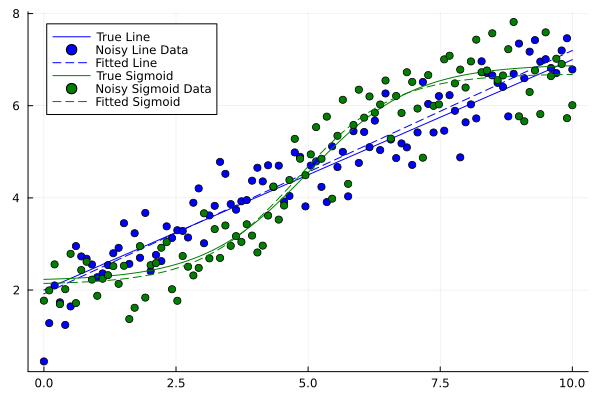

In [19]:
# Run the entire program

run_program()